In [ ]:
import os
import sys

import numpy as np
import pandas as pd

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
import pickle as pkl

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

from utils.utils import calculate_var, filter_variance

In [ ]:
yy_full = pd.read_csv("../data/Data/WDR91/train_LABEL.csv")["LABEL"]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

splits = []
for train_index, test_index in kf.split(yy_full):
    splits.append(
        {
            "train_index": train_index,
            "test_index": test_index,
        }
    )
splits = pd.DataFrame(splits)
splits.to_parquet(
    "../data/Data/WDR91/splits/5-fold-cv-splits.parquet",
    index=False,
)

In [2]:
def load_data(file_path, yy_full, threshold=0.1, top_n=None):
    train_ = pd.read_parquet(file_path)
    vars_, pvals_, means_group0_, means_group1_ = calculate_var(train_, yy_full)
    filt_feats_ = filter_variance(train_, vars_, threshold=threshold, top_n=top_n)

    filt_vars = vars_[filt_feats_]
    filt_means_group0_ = means_group0_[filt_feats_]
    filt_means_group1_ = means_group1_[filt_feats_]

    train_filt_ = train_.loc[:, filt_feats_]

    print(
        train_filt_.shape,
        filt_vars.shape,
        filt_means_group0_.shape,
        filt_means_group1_.shape,
    )

    return filt_feats_, train_filt_, filt_vars, filt_means_group0_, filt_means_group1_

In [3]:
def load_data_top_n(file_path, yy_full, top_n=None):
    train_ = pd.read_parquet(file_path)
    vars_, pvals_, means_group0_, means_group1_ = calculate_var(train_, yy_full)

    vars_ = pd.Series(vars_).sort_values(ascending=False)
    if top_n is not None:
        filt_feats_ = vars_.index[:top_n]
        filt_vars = vars_[:top_n]
        filt_means_group0_ = means_group0_[filt_feats_]
        filt_means_group1_ = means_group1_[filt_feats_]
        train_filt_ = train_.loc[:, filt_feats_]

    else:
        filt_feats_ = vars_.index
        filt_vars = vars_
        filt_means_group0_ = means_group0_
        filt_means_group1_ = means_group1_
        train_filt_ = train_

    print(
        train_filt_.shape,
        filt_vars.shape,
        filt_means_group0_.shape,
        filt_means_group1_.shape,
    )
    return filt_feats_, train_filt_, filt_vars, filt_means_group0_, filt_means_group1_

In [4]:
def normalize_data(xx_full):
    print("Normalizing data...")
    scaler = MinMaxScaler(feature_range=(0, 1))

    xx_full_scaled = pd.DataFrame(
        scaler.fit_transform(xx_full),
        columns=xx_full.columns,
        index=xx_full.index,
    )
    return xx_full_scaled, scaler

In [5]:
def eval_and_report_model(xx_test, yy_test, model):
    yy_pred = model.predict(xx_test)
    print(f"{model.__class__.__name__} Classification Report:")
    print(classification_report(yy_test, yy_pred))
    print(f"{model.__class__.__name__} Accuracy:", accuracy_score(yy_test, yy_pred))
    cm = confusion_matrix(yy_test, yy_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap="Blues", values_format="d")

    # class wise accuracy
    class_wise_accuracy = pd.DataFrame(
        {
            "Class": model.classes_,
            "Accuracy": [
                accuracy_score(yy_test[yy_test == cls], yy_pred[yy_test == cls])
                for cls in model.classes_
            ],
        }
    )
    print(f"{model.__class__.__name__} Class-wise Accuracy:")
    print(class_wise_accuracy)

    return yy_pred, cm

In [ ]:
# TOP 500
# ATOMPAIR
(
    filt_feats_ATOMPAIR,
    train_ATOMPAIR,
    vars_ATOMPAIR,
    means_group0_ATOMPAIR,
    means_group1_ATOMPAIR,
) = load_data_top_n("../data/Data/WDR91/train_ATOMPAIR.parquet", yy_full, top_n=500)
# AVALON
(
    filt_feats_AVALON,
    train_AVALON,
    vars_AVALON,
    means_group0_AVALON,
    means_group1_AVALON,
) = load_data_top_n("../data/Data/WDR91/train_AVALON.parquet", yy_full, top_n=500)
# RDK
filt_feats_RDK, train_RDK, vars_RDK, means_group0_RDK, means_group1_RDK = (
    load_data_top_n("../data/Data/WDR91/train_RDK.parquet", yy_full, top_n=500)
)

# REST OF THE DATA
filt_feats_ECFP4, train_ECFP4, vars_ECFP4, means_group0_ECFP4, means_group1_ECFP4 = (
    load_data_top_n("../data/Data/WDR91/train_ECFP4.parquet", yy_full, top_n=500)
)
filt_feats_ECFP6, train_ECFP6, vars_ECFP6, means_group0_ECFP6, means_group1_ECFP6 = (
    load_data_top_n("../data/Data/WDR91/train_ECFP6.parquet", yy_full, top_n=500)
)
filt_feats_FCFP4, train_FCFP4, vars_FCFP4, means_group0_FCFP4, means_group1_FCFP4 = (
    load_data_top_n("../data/Data/WDR91/train_FCFP4.parquet", yy_full, top_n=500)
)
filt_feats_FCFP6, train_FCFP6, vars_FCFP6, means_group0_FCFP6, means_group1_FCFP6 = (
    load_data_top_n("../data/Data/WDR91/train_FCFP6.parquet", yy_full, top_n=500)
)
filt_feats_MACCS, train_MACCS, vars_MACCS, means_group0_MACCS, means_group1_MACCS = (
    load_data_top_n("../data/Data/WDR91/train_MACCS.parquet", yy_full, top_n=500)
)
(
    filt_feats_TOPTOR,
    train_TOPTOR,
    vars_TOPTOR,
    means_group0_TOPTOR,
    means_group1_TOPTOR,
) = load_data_top_n("../data/Data/WDR91/train_TOPTOR.parquet", yy_full, top_n=500)

100%|██████████| 2048/2048 [00:15<00:00, 133.80it/s]


(375595, 500) (500,) (500,) (500,)


100%|██████████| 2048/2048 [00:14<00:00, 138.71it/s]


(375595, 500) (500,) (500,) (500,)


 53%|█████▎    | 1094/2048 [00:07<00:06, 138.07it/s]/home/rintukutum/miniconda3/envs/dream-target35-python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 2048/2048 [00:14<00:00, 137.78it/s]


(375595, 500) (500,) (500,) (500,)


100%|██████████| 2048/2048 [00:14<00:00, 138.96it/s]


(375595, 500) (500,) (500,) (500,)


100%|██████████| 2048/2048 [00:14<00:00, 139.03it/s]


(375595, 500) (500,) (500,) (500,)


100%|██████████| 2048/2048 [00:15<00:00, 132.03it/s]


(375595, 500) (500,) (500,) (500,)


100%|██████████| 2048/2048 [00:14<00:00, 138.13it/s]


(375595, 500) (500,) (500,) (500,)


 84%|████████▍ | 141/167 [00:01<00:00, 139.63it/s]/home/rintukutum/miniconda3/envs/dream-target35-python/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 167/167 [00:01<00:00, 139.29it/s]


(375595, 167) (167,) (167,) (167,)


100%|██████████| 2048/2048 [00:15<00:00, 135.31it/s]


(375595, 500) (500,) (500,) (500,)


In [ ]:
# Rename columns to avoid conflicts
train_ATOMPAIR.columns = [f"ATOMPAIR_{col}" for col in train_ATOMPAIR.columns]
train_AVALON.columns = [f"AVALON_{col}" for col in train_AVALON.columns]
train_RDK.columns = [f"RDK_{col}" for col in train_RDK.columns]
train_ECFP4.columns = [f"ECFP4_{col}" for col in train_ECFP4.columns]
train_ECFP6.columns = [f"ECFP6_{col}" for col in train_ECFP6.columns]
train_FCFP4.columns = [f"FCFP4_{col}" for col in train_FCFP4.columns]
train_FCFP6.columns = [f"FCFP6_{col}" for col in train_FCFP6.columns]
train_MACCS.columns = [f"MACCS_{col}" for col in train_MACCS.columns]
train_TOPTOR.columns = [f"TOPTOR_{col}" for col in train_TOPTOR.columns]

In [10]:
# COMBINE FEATURES -- all train_
train_COMBINED = pd.concat(
    [
        train_ATOMPAIR,
        train_AVALON,
        train_RDK,
        train_ECFP4,
        train_ECFP6,
        train_FCFP4,
        train_FCFP6,
        train_MACCS,
        train_TOPTOR,
    ],
    axis=1,
)
print(train_COMBINED.shape)
train_COMBINED

(375595, 4167)


,ATOMPAIR_312,ATOMPAIR_124,ATOMPAIR_1089,ATOMPAIR_254,ATOMPAIR_944,ATOMPAIR_61,ATOMPAIR_1669,ATOMPAIR_1009,ATOMPAIR_1024,ATOMPAIR_883,...,TOPTOR_243,TOPTOR_1530,TOPTOR_725,TOPTOR_146,TOPTOR_1414,TOPTOR_1892,TOPTOR_1401,TOPTOR_295,TOPTOR_1700,TOPTOR_1932
0,9,7,2,8,5,6,3,5,2,5,...,0,0,0,0,1,0,0,0,0,0
1,7,6,1,7,5,4,5,5,1,3,...,0,0,0,0,0,0,0,0,0,0
2,9,7,4,6,9,5,5,3,1,7,...,0,0,0,0,0,0,0,0,0,0
3,8,4,2,4,1,3,6,2,4,4,...,0,0,0,0,0,0,0,0,0,0
4,10,5,1,5,6,11,0,12,1,6,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375590,6,4,1,5,3,1,2,1,2,2,...,0,0,0,0,0,0,0,0,0,0
375591,5,12,0,10,11,5,0,6,2,8,...,0,0,0,0,0,0,0,0,0,1
375592,10,5,8,4,6,4,4,5,6,5,...,0,0,0,0,0,0,0,0,0,0
375593,11,10,2,5,4,8,8,8,6,4,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# filt_feats_ATOMPAIR
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_ATOMPAIR.pkl", "wb") as f:
    pkl.dump(filt_feats_ATOMPAIR, f)
# filt_feats_AVALON
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_AVALON.pkl", "wb") as f:
    pkl.dump(filt_feats_AVALON, f)
# filt_feats_RDK
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_RDK.pkl", "wb") as f:
    pkl.dump(filt_feats_RDK, f)
# filt_feats_ECFP4
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_ECFP4.pkl", "wb") as f:
    pkl.dump(filt_feats_ECFP4, f)
# filt_feats_ECFP6
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_ECFP6.pkl", "wb") as f:
    pkl.dump(filt_feats_ECFP6, f)
# filt_feats_FCFP4
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_FCFP4.pkl", "wb") as f:
    pkl.dump(filt_feats_FCFP4, f)
# filt_feats_FCFP6
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_FCFP6.pkl", "wb") as f:
    pkl.dump(filt_feats_FCFP6, f)
# filt_feats_MACCS
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_MACCS.pkl", "wb") as f:
    pkl.dump(filt_feats_MACCS, f)
# filt_feats_TOPTOR
with open("../model/COMBINED-5F-VAR-0-1/filt_feats_TOPTOR.pkl", "wb") as f:
    pkl.dump(filt_feats_TOPTOR, f)

In [ ]:
train_COMBINED_scaled, scaler_COMBINED = normalize_data(train_COMBINED)
os.makedirs("../model/COMBINED-5F-VAR-0-1", exist_ok=True)

with open("../model/COMBINED-5F-VAR-0-1/norm_scaler.pkl", "wb") as f:
    pkl.dump(scaler_COMBINED, f)

train_COMBINED.to_csv("../model/COMBINED-5F-VAR-0-1/train_COMBINED.csv", index=True)

Normalizing data...


In [16]:
filt_feats_TOPTOR

Index([  95,   94, 1360,  428,  429,  163, 1407, 1506,  453, 1352,
       ...
        243, 1530,  725,  146, 1414, 1892, 1401,  295, 1700, 1932],
      dtype='int64', length=500)

In [14]:
scale_pos_weight = 346817 / 28778
os.makedirs("../model/COMBINED-5F-VAR-0-1/folds", exist_ok=True)

Fold 1
Train shape: (300476, 4167), Test shape: (75119, 4167)
Training XGBoost Classifier with 2000 estimators...
Evaluating XGBoost Classifier with 2000 estimators...
XGBClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     69367
           1       0.84      0.83      0.84      5752

    accuracy                           0.98     75119
   macro avg       0.91      0.91      0.91     75119
weighted avg       0.97      0.98      0.98     75119

XGBClassifier Accuracy: 0.9750529160398834
XGBClassifier Class-wise Accuracy:
   Class  Accuracy
0      0  0.986766
1      1  0.833797
Fold 2
Train shape: (300476, 4167), Test shape: (75119, 4167)
Training XGBoost Classifier with 2000 estimators...
Evaluating XGBoost Classifier with 2000 estimators...
XGBClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     69397
           1       

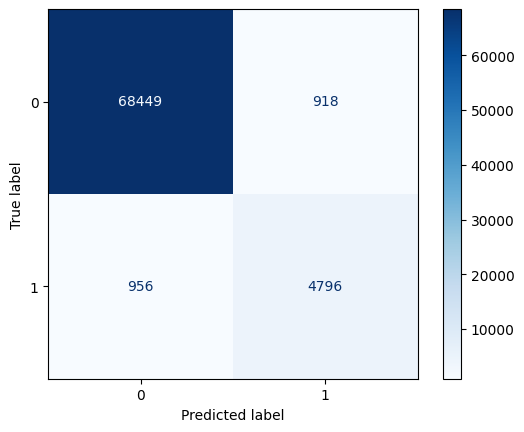

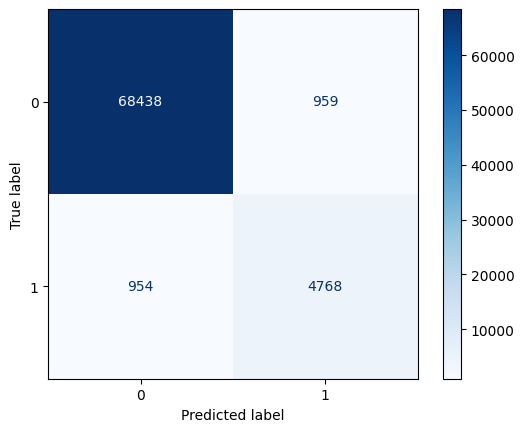

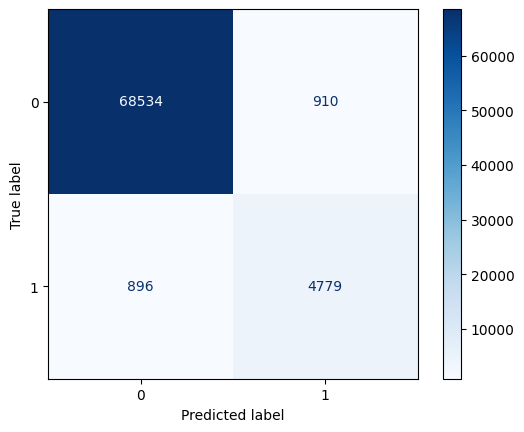

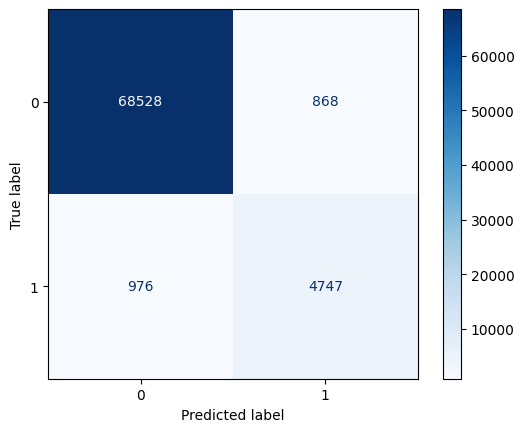

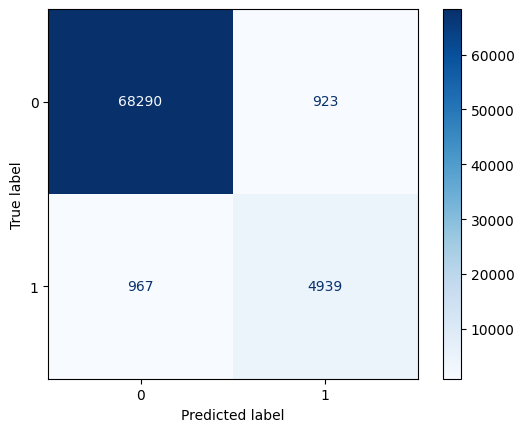

In [15]:
# 5 fold cross-validation
for fold, (train_index, test_index) in enumerate(splits.itertuples(index=False)):
    print(f"Fold {fold + 1}")
    os.makedirs(f"../model/COMBINED-5F-VAR-0-1/folds/fold_{fold + 1}", exist_ok=True)

    xx_train = train_COMBINED_scaled.iloc[train_index]
    yy_train = yy_full.iloc[train_index]
    xx_test = train_COMBINED_scaled.iloc[test_index]
    yy_test = yy_full.iloc[test_index]
    print(f"Train shape: {xx_train.shape}, Test shape: {xx_test.shape}")

    xgb_COMBINED_2000 = XGBClassifier(
        n_estimators=2000, random_state=42, scale_pos_weight=scale_pos_weight
    )
    print("Training XGBoost Classifier with 2000 estimators...")
    xgb_COMBINED_2000.fit(xx_train, yy_train)

    with open(
        f"../model/COMBINED-5F-VAR-0-1/folds/fold_{fold + 1}/xgb_COMBINED_2000.pkl",
        "wb",
    ) as f:
        pkl.dump(xgb_COMBINED_2000, f)

    print("Evaluating XGBoost Classifier with 2000 estimators...")
    yy_pred_COMBINED_xgb_2000, cm_COMBINED_xgb_2000 = eval_and_report_model(
        xx_test=xx_test, yy_test=yy_test, model=xgb_COMBINED_2000
    )
    np.save(
        f"../model/COMBINED-5F-VAR-0-1/folds/fold_{fold + 1}/yy_pred_COMBINED_xgb_2000.npy",
        yy_pred_COMBINED_xgb_2000,
    )